## For Colabs

In [1]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')

os.environ['GITHUB_AUTH'] = user + ':' + password
os.chdir("/content")
!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")

github password··········
Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 549 (delta 66), reused 56 (delta 25), pack-reused 446
Receiving objects: 100% (549/549), 9.26 MiB | 25.41 MiB/s, done.
Resolving deltas: 100% (304/304), done.


In [1]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

ModuleNotFoundError: No module named 'google.colab'

## Loading Packages

In [3]:
import os
os.chdir("Src")

In [4]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


True

### Insuring that training is done on GPU if available

In [25]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Loading Data

In [26]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "Cu")
use_lg_returns = False

## Preprocessing

In [27]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Generating the dataset
if use_lg_returns:
    # Lg Returns Only
    df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)
    target_col = "cu_lme"

else:
    # Price Only
    df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)
    target_col = "price_cu_lme"

# Set to False initially
PCA_used = False

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


In [28]:
# Visualise the plots
# visualise_universe(universe_dict)

In [29]:
df_full.head(15)
# df_full.tail(5)

,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci
date,,,,,,,,,,,
2006-09-13,69540.0,7484.5,3.3925,15748.0,537.35,3.2530,4129.0,4.901,11.18,120.44,438.38855
2006-09-14,71350.0,7439.0,3.3820,14180.0,537.73,3.2475,4207.0,4.926,11.55,119.47,433.72522
2006-09-15,69400.0,7281.0,3.3165,14775.0,537.10,3.2480,4258.0,4.939,11.76,135.25,431.58291
2006-09-18,69830.0,7459.0,3.4180,15263.0,537.10,3.2450,4279.0,4.949,11.78,127.35,434.97293
2006-09-19,71470.0,7516.0,3.3755,17523.0,537.10,3.2450,4275.0,4.948,11.98,125.03,426.51240
2006-09-20,69610.0,7474.0,3.3700,18091.0,537.80,3.2450,4244.0,4.937,11.39,122.71,418.32234
2006-09-21,70170.0,7602.0,3.4220,19546.0,539.70,3.2480,4200.0,4.921,12.25,119.68,423.56908
2006-09-22,71170.0,7601.0,3.4395,20627.0,538.50,3.2470,4136.0,4.924,12.59,118.86,418.01647
2006-09-25,71130.0,7560.0,3.4475,20978.0,539.30,3.2490,4069.0,4.907,12.12,120.75,418.93144


### Normalizing the dataset

In [30]:
# Forecast length
forecast_length = 5
# forecast_length = 22
# forecast_length = 66
# forecast_length = 132

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[[target_col]]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = data_y[forecast_length:, :]

### PCA

In [31]:
# Reducing the dataset to containing a threshold amount of variance
n_dim = dimension_selector(data_X, thresh=0.95)
data_X = dimension_reduce(data_X, n_dim)

PCA_used = True

Number of dimensions: 6
Explained Variance: [0.49081574 0.23242886 0.14340036 0.04819284 0.02760431 0.02205961] 
Explained Variance Sum: 0.9645017204693697


### Slicing Series into Windows

In [32]:
# The input size of each time series window
series_length = 132
print(series_length)
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=1.0)

132


### Hyperparameters

In [62]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 128
test_batch_size = 1000
# series_length = 100

# Training Parameters
n_epochs = 20000
patience = 40
disp_freq= 10
fig_disp_freq= 10


# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 8
dense_hidden = 32
num_layers = 2
output_dim = 1
dropout = 0.0

### Initialising the model

In [63]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim,
             dense_hidden=dense_hidden,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 6 
hidden_dim 8
series_length 132 
batch_size 128
output_dim 1 
num_layers 2
data_X  (3216, 132, 6) 
data_y (3216, 1)


In [64]:
# Loading trained model
# model = torch.load("/content/gdrive/My Drive/Chai/Models/Pths/" + "partial_dataset_LSTM_0_1206.pth")
# model.to(device)

Epoch: 0 Train: 36.68450 Val: 37.14831  Time: 2.475  Best Val: 37.14831


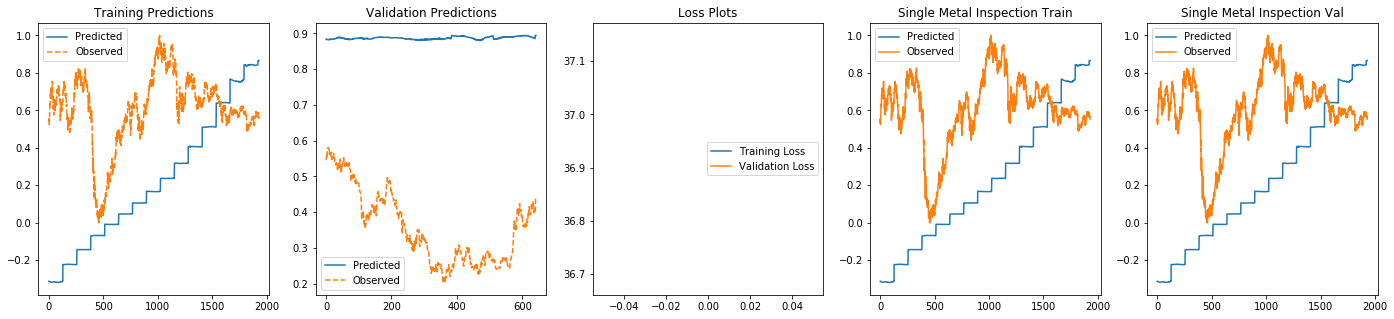

Epoch: 10 Train: 0.48300 Val: 0.11557  Time: 27.719  Best Val: 0.11557


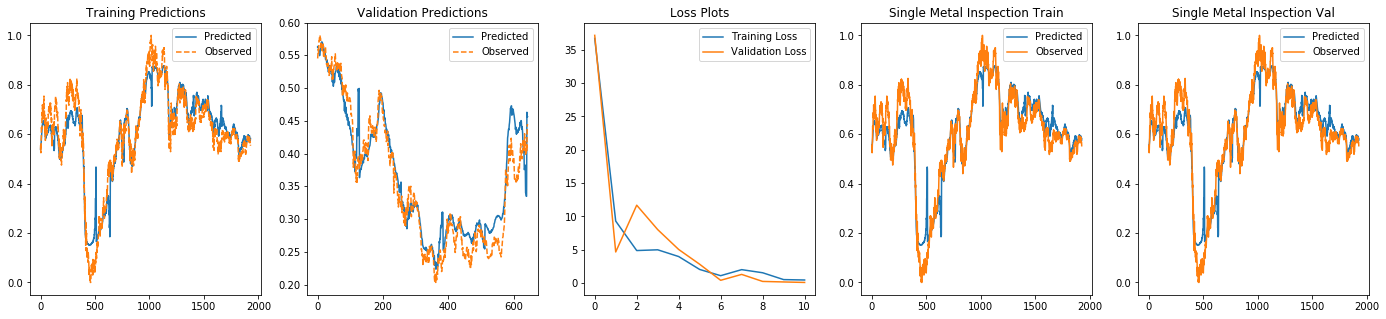

Epoch: 20 Train: 0.79116 Val: 0.58982  Time: 53.139  Best Val: 0.11557


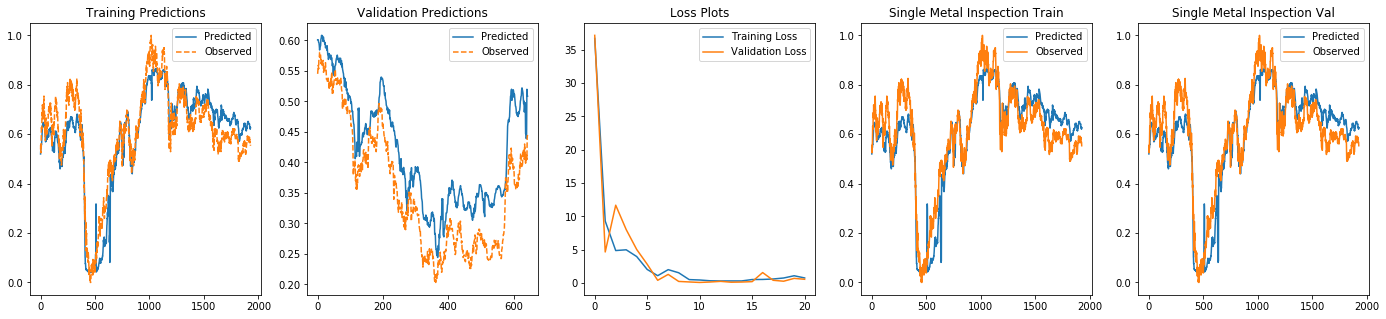

Epoch: 30 Train: 0.66626 Val: 0.47960  Time: 78.672  Best Val: 0.10093


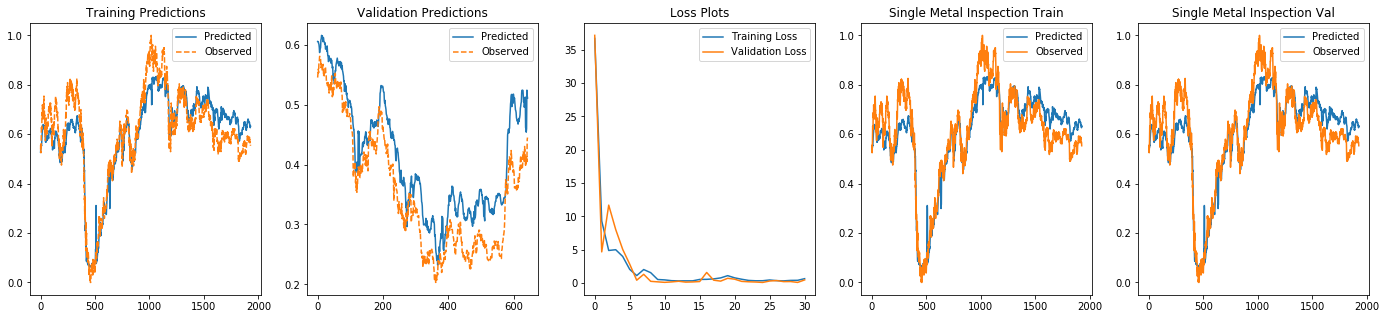

Epoch: 40 Train: 0.67062 Val: 0.28655  Time: 104.104  Best Val: 0.10093


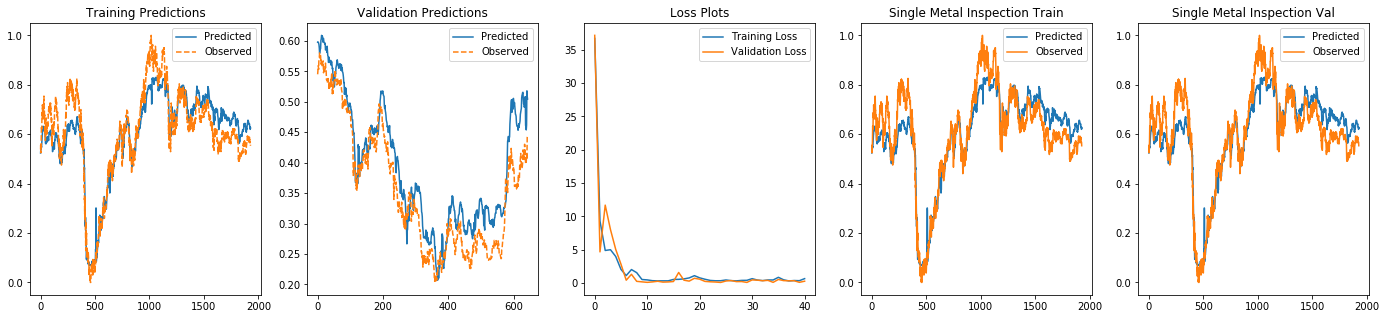

Epoch: 50 Train: 1.19712 Val: 0.24567  Time: 129.562  Best Val: 0.10093


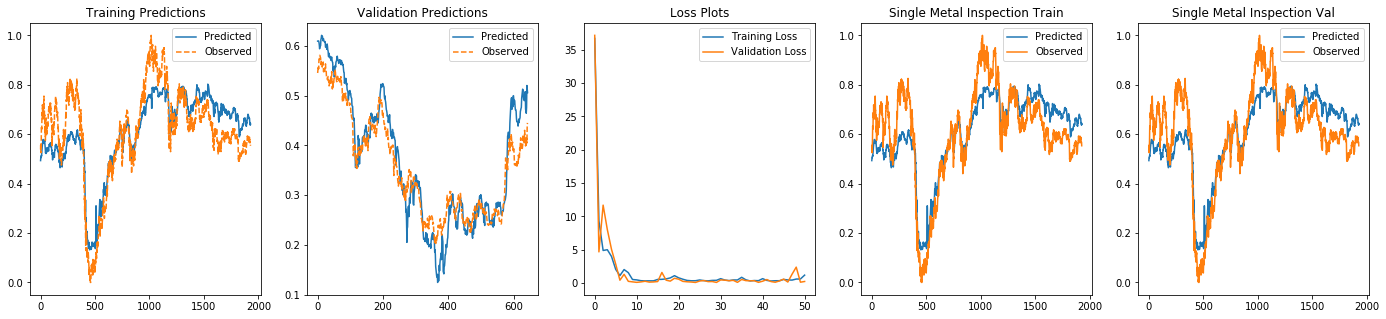

Epoch: 60 Train: 0.35430 Val: 0.21170  Time: 154.960  Best Val: 0.10093


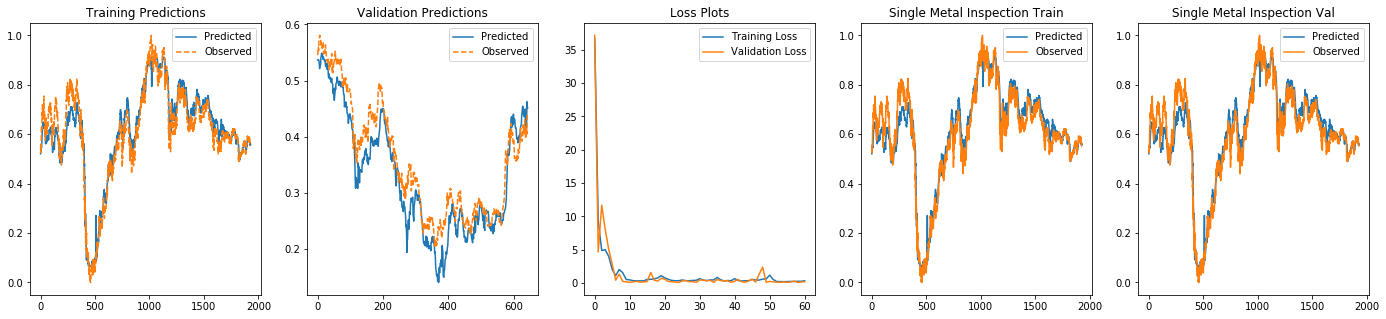

Epoch: 70 Train: 0.24396 Val: 0.42876  Time: 180.505  Best Val: 0.10093


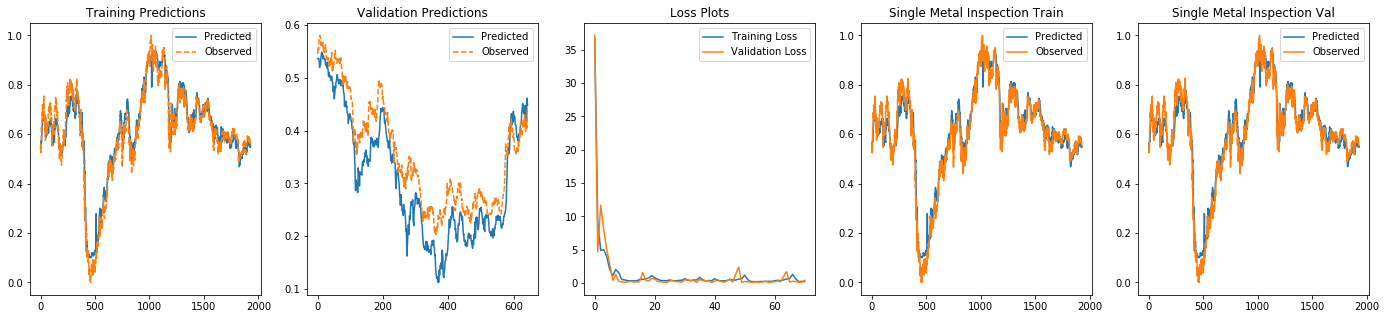

Epoch: 80 Train: 0.29898 Val: 0.47818  Time: 205.909  Best Val: 0.10093


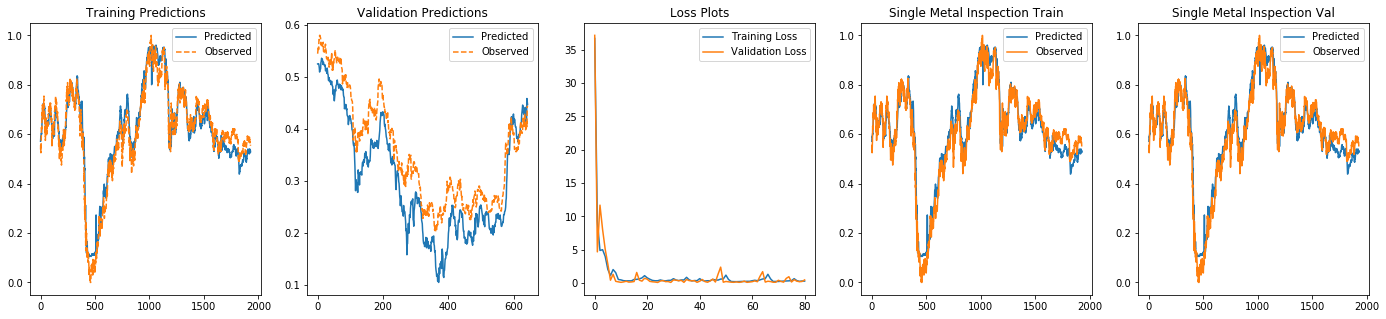

Early Stopping


In [65]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=n_epochs,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=patience, 
                        scaler_data_X=scaler_data_X, 
                        scaler_data_y=scaler_data_y)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()

In [66]:
learning.evaluate(learning.best_model, learning.test_loader)

0.29893549350350634

### Saving Model Object

In [55]:
model_name = "Multivariate" + "_F" + str(forecast_length) + "_W" + str(series_length) + "_Dense" + str(dense_hidden) 
print(model_name)
pickle.dump(learning, open("Results/Pickles/" + model_name, 'wb'))
# pickle.dump(learning, open("/content/gdrive/My Drive/Chai/Models/Pickles/" + obj_name, 'wb'))

Multivariate_F5_W132_Dense32


In [56]:
# learning = pickle.load(open("Results/Pickles/" + "Learning_Univariate_SS_H4_5_", 'rb'))

In [57]:
# model_save(model, 
#            path="/content/gdrive/My Drive/Chai/Models/Pths/",
#            name= "LSTM" + model_name, 
#            val_score=learning.best_val_score)

model_save(model, model_name)

# model = model_load(path="Results/Pths/",
#            model_name="Univariate_SS_H4_5_")

Saving model: Models/Multivariate_F5_W132_Dense32.pth


### Plotting

In [58]:
# Observed
train_true = learning.scaler_data_y.inverse_transform(learning.y_train.numpy())
val_true  = learning.scaler_data_y.inverse_transform(learning.y_val.numpy())
test_true  = learning.scaler_data_y.inverse_transform(learning.y_test.numpy())

# Predicted
train_pred = learning.scaler_data_y.inverse_transform(np.array(learning.train_predictions))
val_pred  = learning.scaler_data_y.inverse_transform(np.array(learning.val_predictions))
test_pred = learning.scaler_data_y.inverse_transform(np.array(learning.test_predictions))

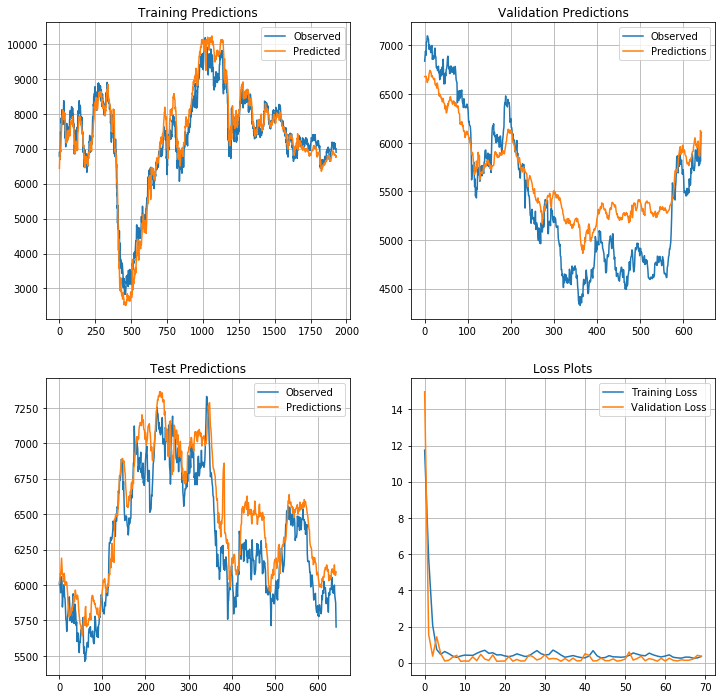

In [59]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()

epoch_reached = str(len(learning.logs['Training Loss']))
path = "Results/Plots/"
val_loss = learning.best_val_score

plt.savefig(path + model_name + ".png")

plt.show()

# Results

In [60]:
mse, mae, mde = evaluate(test_pred, test_true, log_ret=False)
print("Price Metrics: ", 
      mse, mae, mde)

Price Metrics:  46186.58444466944 178.67605007238524 0.5178849144634525


In [61]:
# test_naive = test_true[forecast_length:]
# plt.plot(test_true[:-forecast_length] ,label="Observed")
# plt.plot(test_naive,label="Naive")
# plt.title("Naive vs True")
# plt.grid()
# plt.legend()
# plt.savefig("Results/Plots/" + "Naive_F" + str(forecast_length))
# plt.show()

In [314]:
# mse, mae, mde = evaluate(lg_test_pred, lg_test_true)
# print("Log Returns Metrics: ", 
#       mse, mae, mde)

# mse_naive, mae_naive, mde_naive = evaluate(test_naive, test_true[:-forecast_length], log_ret=False)
# print("naive",
#     mse_naive, mae_naive, mde_naive)

# mse_zeros, mae_zeros, mde_zeros = evaluate(test_zeros, test_true)
# print("Flat",
#     mse_zeros, mae_zeros, mde_zeros)

# mse_increase, mae_increase, mde_increase = evaluate(test_increase, test_true)
# print("Inflation",
#     mse_increase, mae_increase, mde_increase)

ValueError: Found input variables with inconsistent numbers of samples: [631, 565]